In [1]:
# import packages
import os, sys
import string
import numpy as np, pandas as pd
try:
    import nltk
except:
    !conda install --yes --prefix {sys.prefix} nltk
    import nltk
finally:
    nltk.download('stopwords')
    nltk.download('words')
    nltk.download('punkt')
    nltk.download('rslp')

import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !conda install --yes --prefix {sys.prefix} seaborn
    import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score

# import modules
from utils.get_dataset import get_dataframe, subset_dataframe
from utils.preprocessing import label_encoding, new_features, normalize_features, stemming, tokenizer, join_text

# magics
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pmiguere\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pmiguere\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pmiguere\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\pmiguere\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
#----------------------- CONFIG -----------------------#
visualization = True
chunksize = 500
max_features = 1000
#------------------------------------------------------#

### 1) File Exploration

In [3]:
# ver conteúdos da pasta
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'authorship_identification.ipynb',
 'BOA_project_description.pdf',
 'corpora',
 'LICENSE',
 'README.md',
 'requirements.txt',
 'utils']

In [4]:
authors = os.listdir("corpora/train")

In [5]:
if visualization:
    for author in authors:
        for excerto in [x for x in os.listdir(f"corpora/train/{author}") if x.endswith(".txt")]:
            print(f"corpora/train/{author}/{excerto}")

corpora/train/AlmadaNegreiros/pg22615.txt
corpora/train/AlmadaNegreiros/pg22730.txt
corpora/train/AlmadaNegreiros/pg22801.txt
corpora/train/AlmadaNegreiros/pg22802.txt
corpora/train/AlmadaNegreiros/pg22969.txt
corpora/train/AlmadaNegreiros/pg23133.txt
corpora/train/AlmadaNegreiros/pg23620.txt
corpora/train/AlmadaNegreiros/pg23879.txt
corpora/train/AlmadaNegreiros/pg23961.txt
corpora/train/CamiloCasteloBranco/24691-0.txt
corpora/train/CamiloCasteloBranco/34756-0.txt
corpora/train/CamiloCasteloBranco/pg16425.txt
corpora/train/CamiloCasteloBranco/pg17927.txt
corpora/train/CamiloCasteloBranco/pg19375.txt
corpora/train/CamiloCasteloBranco/pg21406.txt
corpora/train/CamiloCasteloBranco/pg23203.txt
corpora/train/CamiloCasteloBranco/pg23345.txt
corpora/train/CamiloCasteloBranco/pg23346.txt
corpora/train/CamiloCasteloBranco/pg24339.txt
corpora/train/CamiloCasteloBranco/pg25844.txt
corpora/train/CamiloCasteloBranco/pg26017.txt
corpora/train/CamiloCasteloBranco/pg26103.txt
corpora/train/CamiloCast

___
### 2) Train

In [6]:
train = get_dataframe(path_to_train="corpora/train/", author_list=authors,
                      preserve_blank_lines=False, join_every_line=True,
                      separator=" ")

train.head(2)

,text,author
0,Title: A Scena do Odio Author: José de Almada ...,AlmadaNegreiros
1,Title: O Jardim da Pierrette Author: José de A...,AlmadaNegreiros


In [7]:
fd = nltk.FreqDist(w.lower() for w in train.loc[0, "text"].split())

{token: freq for token, freq in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

{'de': 84,
 'e': 73,
 'a': 63,
 'ó': 51,
 'da': 48,
 'do': 39,
 'que': 35,
 'o': 30,
 'dos': 24,
 'hei-de': 23,
 'das': 18,
 'no': 16,
 'sou': 14,
 'na': 12,
 'tambem,': 12,
 'as': 11,
 'em': 11,
 'não': 11,
 'com': 11,
 'os': 10,
 'por': 10,
 'eu': 10,
 'larga': 10,
 'ser': 9,
 'sem': 9,
 'tu': 9,
 'ahi!': 9,
 'zutt!': 7,
 'esse': 7,
 'meu': 6,
 'me': 6,
 'vós': 6,
 'sobre': 5,
 'mas': 5,
 'nem': 5,
 'ter': 5,
 'nos': 4,
 'cantar': 4,
 'uma': 4,
 'ao': 4,
 "co'a": 4,
 'cidade!': 4,
 'ti': 4,
 'vida': 3,
 'só': 3,
 'voz': 3,
 'nero,': 3,
 'nas': 3,
 'nasci': 3,
 'praga': 3,
 'ciumes!': 3,
 'sete': 3,
 'pragas': 3,
 'nylo': 3,
 'alma': 3,
 'borgias': 3,
 'penar!': 3,
 'vivo': 3,
 'tantos': 3,
 'genios': 3,
 'tua': 3,
 'fazer': 3,
 'sciencia': 3,
 'teu': 3,
 'carne': 3,
 'depois': 3,
 'has-de': 3,
 'pagar-me': 3,
 'odio': 2,
 'campos': 2,
 'três': 2,
 'vara': 2,
 'inferno': 2,
 'raiva': 2,
 'sina!': 2,
 'agora': 2,
 'quero': 2,
 'virgem': 2,
 'opiado': 2,
 'attila,': 2,
 'eu!': 2,
 'meus

In [8]:
train = new_features(train, "text")
train["tokens"] = train["text"].apply(tokenizer)

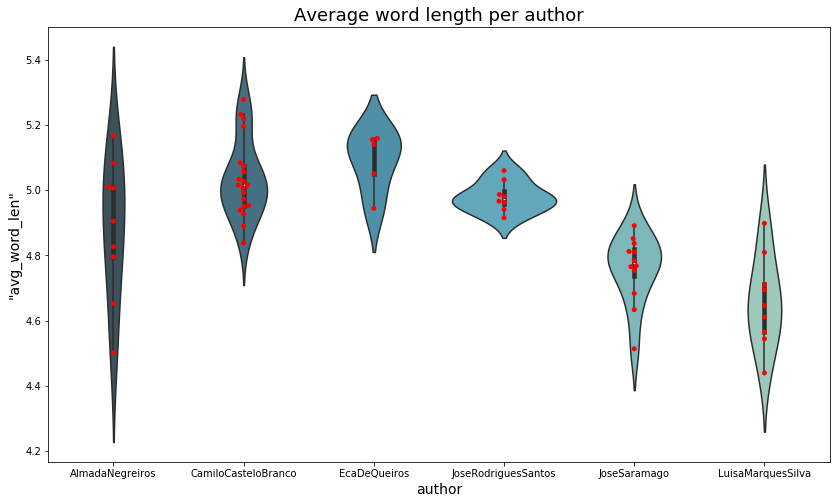

In [9]:
if visualization:
    plt.figure(figsize=(14,8))
    sns.violinplot(x="author", y="avg_word_len", data=train, palette="GnBu_d")
    sns.swarmplot(x="author", y="avg_word_len", data=train, color="r", alpha=1)
    plt.ylabel("\"avg_word_len\"", fontsize=14)
    plt.xlabel("author", fontsize=14)
    plt.title("Average word length per author", fontsize=18)
    plt.show()

In [10]:
traindf, indexes_mapping = subset_dataframe(train, chunksize=chunksize)

traindf.head(2)

,author,tokens
0,AlmadaNegreiros,"[title, :, a, scena, do, odio, author, :, josé..."
1,AlmadaNegreiros,"[sinto, ,, claramente, ,, que, nasci, de, uma,..."


In [11]:
len(traindf)

8386

In [12]:
traindf.author.value_counts()

JoseRodriguesSantos    2840
JoseSaramago           2366
CamiloCasteloBranco    1867
EcaDeQueiros           1097
AlmadaNegreiros         112
LuisaMarquesSilva       104
Name: author, dtype: int64

LuisaMarquesSilva is clearly under-represented in this dataset. We should expect that to be an underperforming class.

In [13]:
# sanity check - chunks of 500 tokens
traindf.tokens.str.len().describe()

count    8386.000000
mean      498.099213
std        24.611954
min        30.000000
25%       500.000000
50%       500.000000
75%       500.000000
max       500.000000
Name: tokens, dtype: float64

In [14]:
traindf.head()

,author,tokens
0,AlmadaNegreiros,"[title, :, a, scena, do, odio, author, :, josé..."
1,AlmadaNegreiros,"[sinto, ,, claramente, ,, que, nasci, de, uma,..."
2,AlmadaNegreiros,"[e, vos, tambem, ,, theoricos-irmãos-gemeos, d..."
3,AlmadaNegreiros,"[!, acouraça-te, de, senso, ,, vomita, de, vez..."
4,AlmadaNegreiros,"[nêgra, !, hei-de, despir-te, a, pelle, a, pou..."


In [15]:
traindf["tokens"] = traindf["tokens"].apply(stemming)

traindf.head(2)

,author,tokens
0,AlmadaNegreiros,"[titl, scen, odi, auth, josé, alm, negr, relea..."
1,AlmadaNegreiros,"[sint, cl, nasc, prag, cium, set, prag, sobr, ..."


In [16]:
tfidf_vector = TfidfVectorizer(
    stop_words = nltk.corpus.stopwords.words('portuguese'),
    tokenizer = tokenizer,
    max_features = max_features
    )

In [17]:
traindf["tokens"] = traindf["tokens"].apply(join_text)

In [18]:
# traindf = new_features(traindf, "tokens")

In [19]:
tfidf_vector.fit(traindf["tokens"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                            'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                            'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                            'ao', 'ele', 'das', 'à', 'seu', 'sua', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer at 0x000001B97AFC6708>,
                use_idf=True, vocabulary=None)

In [20]:
result = tfidf_vector.transform(traindf["tokens"]).toarray()

In [21]:
result.shape

(8386, 1000)

In [22]:
print(tfidf_vector.get_feature_names())

["'", '--', '.', '...', '``', 'aban', 'abandon', 'abert', 'abr', 'abraç', 'absolut', 'acab', 'aceit', 'ach', 'acompanh', 'acontec', 'acord', 'acredit', 'acrescent', 'act', 'adiant', 'admir', 'adormec', 'afast', 'affons', 'afinal', 'afirm', 'afons', 'agarr', 'agnè', 'agor', 'ah', 'ahi', 'ahmed', 'ai', 'aind', 'ajud', 'alegr', 'alem', 'alg', 'algum', 'alguém', 'ali', 'aliment', 'all', 'alm', 'almoç', 'alt', 'altur', 'alá', 'além', 'am', 'ama', 'amanhã', 'ambos', 'ameaç', 'americ', 'amig', 'amél', 'and', 'anim', 'animal', 'anj', 'ann', 'ano', 'ant', 'antig', 'antoni', 'antóni', 'apanh', 'aparec', 'apen', 'apert', 'apes', 'apont', 'apparec', 'aprend', 'apresent', 'aproxim', 'aqu', 'aquell', 'ar', 'are', 'arm', 'arranc', 'arranj', 'art', 'assent', 'assim', 'assist', 'assunt', 'atalh', 'atenç', 'atir', 'atravess', 'através', 'atrás', 'autor', 'avanç', 'avis', 'azul', 'aí', 'baix', 'baltas', 'banc', 'banh', 'barb', 'barr', 'bast', 'bat', 'beb', 'beij', 'bel', 'bell', 'bem', 'benedit', 'blimun

In [23]:
# codificação da coluna y para fornecer ao futuro modelo
traindf, le = label_encoding(traindf, "author")

train_tfidf = pd.DataFrame(result, columns=tfidf_vector.get_feature_names())

In [24]:
traindf = pd.concat([
    traindf.drop("tokens", axis=1),
    train_tfidf
], axis=1)

In [25]:
traindf.values.shape

(8386, 1001)

In [26]:
X = traindf.values[:, 1:]
y = traindf.values[:, 0]

print(f"X:{X.shape}\ny:{y.shape}")

X:(8386, 1000)
y:(8386,)


___
### 3) Classification Model

In [27]:
seed = 2020

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [28]:
clf1 = LogisticRegressionCV(tol=1e-5, class_weight="balanced", random_state=seed, solver="lbfgs",
                                       max_iter=1000, multi_class="multinomial", cv=kfold)
clf2 = RandomForestClassifier(class_weight="balanced", n_estimators=1000, random_state=seed)
clf3 = MultinomialNB()

estimators = [('lr', clf1), ('rf', clf2), ('nb', clf3)]

eclf = VotingClassifier(estimators=estimators,
                        voting='soft',
                        flatten_transform=True)

In [29]:
results = cross_val_score(eclf, X, y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 98.40% (0.31%)


In [30]:
eclf.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegressionCV(Cs=10,
                                                   class_weight='balanced',
                                                   cv=KFold(n_splits=5, random_state=2020, shuffle=True),
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None,
                                                   max_iter=1000,
                                                   multi_class='multinomial',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=2020,
                                                   refit=True, scoring=None,
                                                   solver='lbfgs', tol=1e-05,
  

___
### 4) Model predictions

In [31]:
test = get_dataframe("corpora/test/", author_list=["1000Palavras", "500Palavras"],
                     preserve_blank_lines=False, join_every_line=True,
                     separator=" ")

test["tokens"] = test["text"].apply(tokenizer)

# testdf = subset_dataframe(test, chunksize=chunksize)
testdf = test.copy()
testdf["tokens"] = testdf["tokens"].apply(stemming)
testdf["tokens"] = testdf["tokens"].apply(join_text)
testresult = tfidf_vector.transform(testdf["tokens"]).toarray()
test_tfidf = pd.DataFrame(testresult, columns=tfidf_vector.get_feature_names())
Xtest = test_tfidf.values
preds = le.inverse_transform(eclf.predict(Xtest).astype(int))

In [32]:
pd.DataFrame(le.inverse_transform(eclf.predict(Xtest).astype(int)), columns=["author"])["author"].value_counts()

JoseSaramago           4
AlmadaNegreiros        2
CamiloCasteloBranco    2
JoseRodriguesSantos    2
EcaDeQueiros           2
Name: author, dtype: int64

___
### 5) Hard evaluation

**Note:** Evaluating on test set given the fact that the train dataset is small for train/valid split, which is not desirable.

In [33]:
# manually set labels
labels = ["JoseSaramago", "AlmadaNegreiros", "LuisaMarquesSilva",
          "EcaDeQueiros", "CamiloCasteloBranco", "JoseRodriguesSantos",
          "JoseSaramago", "LuisaMarquesSilva", "LuisaMarquesSilva",
          "EcaDeQueiros", "CamiloCasteloBranco", "JoseRodriguesSantos"]

score, certos, errados = 0, [], []

for index, i in enumerate(preds):
    if i == labels[index]:
        print(f"#{index}: correct! \n\t\tpredicted:\t{i}\n\t\tlabel:\t\t{labels[index]}\n")
        score += 1
        certos.append(index)
    else:
        print(f"#{index}: WRONG <------------------------------\n\t\tpredicted:\t{i}\n\t\tlabel:\t\t{labels[index]}\n")

accuracy = round(score/len(test)*100, 2)
print(f"\naccuracy = {accuracy} %")

#0: correct! 
		predicted:	JoseSaramago
		label:		JoseSaramago

#1: correct! 
		predicted:	AlmadaNegreiros
		label:		AlmadaNegreiros

#2: WRONG <------------------------------
		predicted:	JoseSaramago
		label:		LuisaMarquesSilva

#3: correct! 
		predicted:	EcaDeQueiros
		label:		EcaDeQueiros

#4: correct! 
		predicted:	CamiloCasteloBranco
		label:		CamiloCasteloBranco

#5: correct! 
		predicted:	JoseRodriguesSantos
		label:		JoseRodriguesSantos

#6: correct! 
		predicted:	JoseSaramago
		label:		JoseSaramago

#7: WRONG <------------------------------
		predicted:	AlmadaNegreiros
		label:		LuisaMarquesSilva

#8: WRONG <------------------------------
		predicted:	JoseSaramago
		label:		LuisaMarquesSilva

#9: correct! 
		predicted:	EcaDeQueiros
		label:		EcaDeQueiros

#10: correct! 
		predicted:	CamiloCasteloBranco
		label:		CamiloCasteloBranco

#11: correct! 
		predicted:	JoseRodriguesSantos
		label:		JoseRodriguesSantos


accuracy = 75.0 %


___